In [11]:
%cd ../

/Users/asmazaev/Projects/TensorAeroSpace


/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [12]:
import numpy as np
import gymnasium as gym
import torch
from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step, sinusoid
from tensoraerospace.benchmark.function import overshoot, settling_time, static_error
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensoraerospace.agent.mpc.stochastic import MPCAgent, Net

In [13]:
# Инициализация списка для хранения исторических данных
hist = []
dt = 0.01  # Интервал дискретизации времени

# Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=5, dt=dt) 

# Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# Вычисление общего количества временных шагов
number_time_steps = len(tp) 

# Создание заданного сигнала с использованием единичного шага
# reference_signals = np.reshape(unit_step(degree=0, tp=tp, time_step=20, output_rad=True), [1, -1])
reference_signals = np.reshape(np.deg2rad(sinusoid(amplitude=0.01, tp=tp, frequency=5)), [1, -1])

# Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
env = gym.make('LinearLongitudinalF16-v0',
               number_time_steps=number_time_steps, 
               initial_state=[[0],[0],[0],[0]],
               reference_signal=reference_signals,
               tracking_states=["alpha"])

# Сброс среды к начальному состоянию
state, info = env.reset()

/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


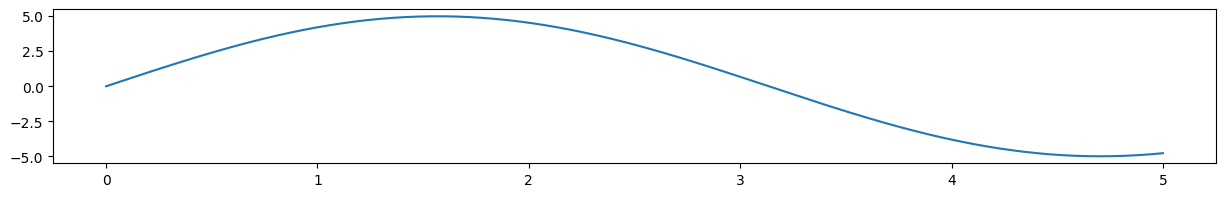

In [14]:
fig = plt.figure(figsize=(15,2))
plt.plot(tps, sinusoid(amplitude=0.01, tp=tp, frequency=5));

In [15]:
model = Net(env.action_space.shape[0], env.observation_space.shape[0])

In [16]:
# env = gym.make("Pendulum-v1")
# import random

# seed = 7777777
# np.random.seed(seed)
# random.seed(seed)

# def example_cost_function(state, action):
#     theta = state[0, 0].item()
#     theta_dot = state[0, 1].item()
#     return (theta ** 2 + 0.1 * theta_dot ** 2 + 0.001 * (action ** 2))

# # Assuming `model`, `env`, and other necessary variables are defined elsewhere

In [17]:
def cost(next_state, action, reference_signals, step):
    # Коэффициенты веса для ошибки состояния и управляющего действия
    Q = 10.0  # Вес ошибки состояния
    R = 0.01  # Вес управляющего действия
    
    # Извлечение текущих значений угла атаки и угловой скорости
    alpha, omega = next_state[0].detach().numpy()
    
    # Получение желаемого значения угла атаки на текущем шаге
    alpha_ref = reference_signals[0][step]
    # Расчет ошибки состояния (разница между текущим и желаемым углом атаки)
    state_error = abs(alpha - alpha_ref)
    
    # Расчет стоимости на основе ошибки состояния и управляющего действия
    cost = Q * (state_error**2)
    return cost

agent = MPCAgent(gamma=0.99, action_dim=1, observation_dim=2, model=model, cost_function=cost, env=env)

In [18]:
states, actions, next_states = agent.collect_data(num_episodes=10)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:246: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(
100%|██████████| 10/10 [00:00<00:00, 20.64it/s]


In [19]:
agent.train_model(states, actions, next_states, epochs=1, batch_size=1)

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 3])
tensor([[-0.0455, -0.0581, 14.5280]])
torch.Size([1, 3])
tensor([[ -0.1187,  -0.1020, -25.0000]])
torch.Size([1, 3])
tensor([[ 0.0512,  0.0654, 14.5112]])
torch.Size([1, 3])
tensor([[ -0.0292,  -0.0484, -25.0000]])
torch.Size([1, 3])
tensor([[ -0.0310,  -0.0496, -25.0000]])
torch.Size([1, 3])
tensor([[ 2.4465e-03,  1.5668e-02, -1.0801e+01]])
torch.Size([1, 3])
tensor([[  0.0946,   0.0849, -25.0000]])
torch.Size([1, 3])
tensor([[ 5.8853e-03,  4.6104e-03, -1.5889e+01]])
torch.Size([1, 3])
tensor([[ -0.0680,  -0.0754, -22.1042]])
torch.Size([1, 3])
tensor([[  0.1138,   0.0945, -11.6180]])
torch.Size([1, 3])
tensor([[ 0.0383,  0.0581, 22.5012]])
torch.Size([1, 3])
tensor([[ -0.1161,  -0.0960, -18.9624]])
torch.Size([1, 3])
tensor([[-0.0215, -0.0422,  9.0977]])
torch.Size([1, 3])
tensor([[ 0.0612,  0.0706, 20.4072]])
torch.Size([1, 3])
tensor([[-0.0751, -0.0787, -9.5023]])
torch.Size([1, 3])
tensor([[6.1747e-03, 2.4902e-02, 2.5000e+01]])
torch.Size([1, 3])
tensor([[0.0813

  0%|          | 0/1 [00:01<?, ?it/s]

torch.Size([1, 3])
tensor([[  0.0638,   0.0739, -12.2527]])
torch.Size([1, 3])
tensor([[ -0.1142,  -0.0925, -25.0000]])
torch.Size([1, 3])
tensor([[ 0.0379,  0.0578, 12.7151]])
torch.Size([1, 3])
tensor([[ -0.1070,  -0.0922, -25.0000]])
torch.Size([1, 3])
tensor([[ 0.0325,  0.0527, 25.0000]])
torch.Size([1, 3])
tensor([[ -0.0732,  -0.0707, -13.0736]])
torch.Size([1, 3])
tensor([[-0.0835, -0.0754, 15.1103]])
torch.Size([1, 3])
tensor([[0.1235, 0.0984, 0.2182]])
torch.Size([1, 3])
tensor([[-2.3284e-03, -1.5449e-02,  2.5000e+01]])
torch.Size([1, 3])
tensor([[ 0.0565,  0.0682, 25.0000]])
torch.Size([1, 3])
tensor([[1.8267e-02, 4.1228e-02, 2.5000e+01]])
torch.Size([1, 3])
tensor([[0.1011, 0.0915, 5.1830]])
torch.Size([1, 3])
tensor([[ -0.0584,  -0.0645, -25.0000]])
torch.Size([1, 3])
tensor([[-2.1523e-02, -4.5117e-02,  2.5000e+01]])
torch.Size([1, 3])
tensor([[-0.0365, -0.0566, 25.0000]])
torch.Size([1, 3])
tensor([[  0.0631,   0.0713, -15.8632]])
torch.Size([1, 3])
tensor([[3.5829e-04, 1.7

KeyboardInterrupt: 

: 

In [ ]:
agent.test_network(states, actions, next_states)

Test MSE Loss: 5.731918406581826e-08


In [ ]:

rollout, horizon = 50,10
for episode in range(1):
    state, info = env.reset()
    episode_reward = 0
    for step in tqdm(range(number_time_steps-2)):
        action = agent.choose_action_ref(state, rollout, horizon, reference_signals, step)
        state, reward, terminated, truncated, info= env.step(action)
        state = state.reshape([1, -1])[0]
        done = terminated or truncated
        episode_reward += reward
        if done:
            break
    print('rollout: %d, horizon: %d, episode: %d, reward: %d' % (rollout, horizon, episode, episode_reward))


  0%|          | 0/499 [00:00<?, ?it/s]

100%|█████████▉| 498/499 [00:13<00:00, 36.21it/s]

rollout: 50, horizon: 10, episode: 0, reward: -311



/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_80026/1615792007.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('rollout: %d, horizon: %d, episode: %d, reward: %d' % (rollout, horizon, episode, episode_reward))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


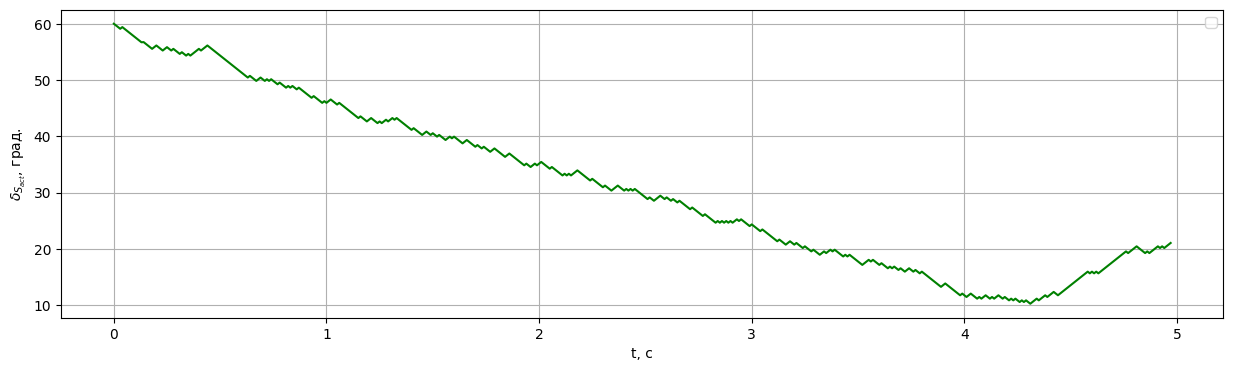

In [ ]:
env.model.plot_control('ele', tps, to_deg=True, figsize=(15,4))

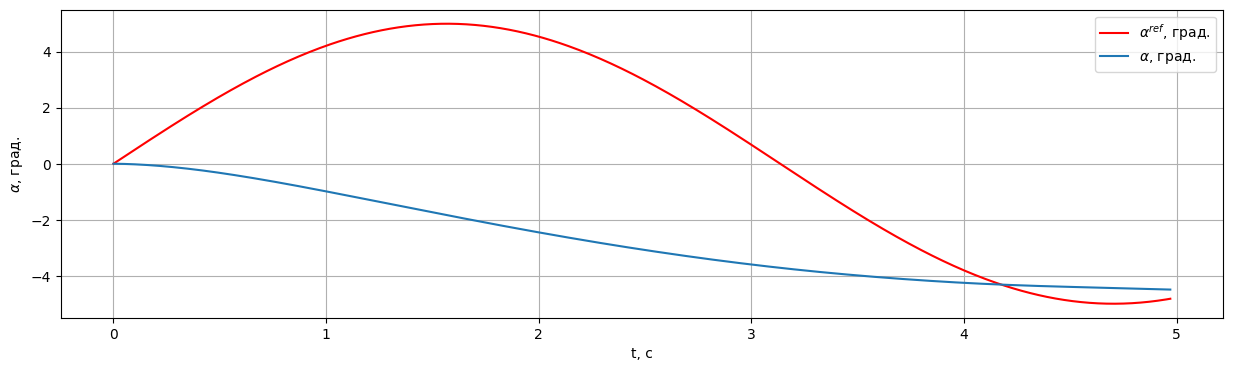

In [ ]:
env.unwrapped.model.plot_transient_process('alpha', tps, reference_signals[0], to_deg=True, figsize=(15,4))